In [6]:
import SimInterface as SI
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

A = np.array([[0,1],
              [0,0]])

B = np.array([[0],
              [1]])

C = np.array([[1,0]])

def stateFun(x,u):
    return np.dot(A,x)+np.dot(B,u)


X = SI.VarArray('x',2)
U = SI.Variable('u')

print X
print U

['x0' 'x1']
u


# Functions and Variables

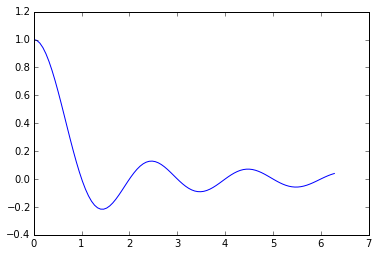

In [2]:
Time = SI.Variable(label='t',value=np.linspace(0,2*np.pi,100))
SineFunc = SI.Function(func=np.sinc,vars=Time)
plt.plot(Time.getValue(),SineFunc.getValue())

In [ ]:
dot = Digraph(comment='The Round Table')
dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')

dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')
dot

In [ ]:
def sineInput(t):
    return np.sin(t)

In [ ]:
np.prod((3,4))

In [ ]:
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        print M[i,j]
        
print M

In [ ]:
np.dtype(('hey',SI.Variable])

In [2]:
arr = np.array([["your"],["mom"],["takes"],["vacation"]])

In [5]:
print arr.__str__()

[['your']
 ['mom']
 ['takes']
 ['vacation']]


In [11]:
tuple([i for i in np.arange(3)])

(0, 1, 2)